In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annafalkjensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
# import data
dr_data = pd.read_csv('dr_frequent_articles.csv', sep = ',')
article_text = dr_data['Text lemmatized'].values
# convert data to a list
data = dr_data.values.tolist()

In [94]:
# convert all articles into lists
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(article_text))

<class 'list'>


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['mexicansk', 'hær', 'befri', 'migrant', 'holde', 'fange', 'gruppe', 'kriminel', 'nordlig', 'mexico', 'offer', 'centralamerika', 'oplyse', 'mexicansk', 'myndighed', 'gruppe', 'migrant', 'inkludere', 'mindrearig', 'fange', 'forsøge_krydse', 'grænse', 'usa', 'baggrund', 'tip', 'lykkes', 'militærstyrke', 'finde', 'frem', 'gruppe', 'holde', 'fange', 'overfylde', 'ejendom', 'ussel', 'usund', 'forhold', 'gustavo', 'diaz', 'ordaz', 'grænse', 'holde', 'vag', 'anholde', 'eftersøge', 'talsmand', 'befri', 'el_salvador_guatemala_honduras', 'enkel', 'indisk', 'statsborger', 'talsmand', 'national', 'ansla', 'rapport', 'ar', 'kidnappe', 'omtrent', 'person', 'mexico', 'familiemedlem', 'usa', 'opkræve', 'løsesum', 'dollar', 'migrant', 'fund', 'dræbe', 'gard', 'tilsyneladende', 'eje', 'narkokartel', 'lo', 'zeta', 'ritzau_afp']


In [6]:
# Define functions for bigrams and trigrams 
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [7]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [8]:
print(data_words[:1])

[['mexicansk', 'hær', 'befri', 'migrant', 'holde', 'fange', 'gruppe', 'kriminel', 'nordlig', 'mexico', 'offer', 'centralamerika', 'oplyse', 'mexicansk', 'myndighed', 'gruppe', 'migrant', 'inkludere', 'mindrearig', 'fange', 'forsøge', 'krydse', 'grænse', 'usa', 'baggrund', 'tip', 'lykkes', 'militærstyrke', 'finde', 'frem', 'gruppe', 'holde', 'fange', 'overfylde', 'ejendom', 'ussel', 'usund', 'forhold', 'gustavo', 'diaz', 'ordaz', 'grænse', 'holde', 'vag', 'anholde', 'eftersøge', 'talsmand', 'befri', 'el', 'salvador', 'guatemala', 'honduras', 'enkel', 'indisk', 'statsborger', 'talsmand', 'national', 'ansla', 'rapport', 'ar', 'kidnappe', 'omtrent', 'person', 'mexico', 'familiemedlem', 'usa', 'opkræve', 'løsesum', 'dollar', 'migrant', 'fund', 'dræbe', 'gard', 'tilsyneladende', 'eje', 'narkokartel', 'lo', 'zeta', 'ritzau', 'afp']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 3), (24, 2), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 2), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1)]]


In [146]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [147]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"barn" + 0.012*"ga" + 0.011*"familie" + 0.011*"fortælle" + '
  '0.011*"ung" + 0.010*"dag" + 0.010*"ar" + 0.009*"bo" + 0.008*"gruppe" + '
  '0.007*"kvinde"'),
 (1,
  '0.057*"indvandrer" + 0.025*"parti" + 0.017*"vestlig" + 0.015*"procent" + '
  '0.013*"politisk" + 0.013*"stemme" + 0.011*"ga" + 0.010*"tale" + '
  '0.009*"valg" + 0.008*"social"'),
 (2,
  '0.056*"asylansøger" + 0.056*"rapport" + 0.039*"sag" + 0.034*"asyl" + '
  '0.028*"norge" + 0.023*"jens" + 0.016*"norsk" + 0.013*"afvise" + '
  '0.013*"afgørelse" + 0.012*"person"'),
 (3,
  '0.048*"eu" + 0.031*"land" + 0.018*"sverige" + 0.018*"europa" + '
  '0.013*"svensk" + 0.013*"tyskland" + 0.012*"thorning" + 0.012*"tysk" + '
  '0.010*"helle" + 0.010*"grænse"'),
 (4,
  '0.035*"danmark" + 0.031*"dansk" + 0.023*"ar" + 0.017*"regering" + '
  '0.015*"flygtning" + 0.014*"land" + 0.009*"mene" + 0.008*"dansker" + '
  '0.008*"tal" + 0.007*"procent"'),
 (5,
  '0.082*"kommune" + 0.056*"flygtning" + 0.033*"arbejde" + 0.026*"job" + '
 

In [148]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.078564260391007

Coherence Score:  0.4521163401219091


In [149]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.239988  0.013447       1        1  28.497210
0     -0.243636  0.010804       2        1  20.296837
7     -0.118816 -0.199710       3        1  13.608652
1     -0.179952  0.177234       4        1  10.275037
3     -0.109965 -0.158545       5        1   9.711452
5     -0.054277  0.235110       6        1   5.405948
8      0.043418 -0.163306       7        1   4.885515
9      0.193317  0.154909       8        1   2.804823
2      0.202450 -0.082255       9        1   2.581180
6      0.248942  0.003715      10        1   1.474655
10     0.258506  0.008597      11        1   0.458695, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
228    Default  10033.000000       flygtning  10033.000000  30.0000  30.0000
1215   Default   3809.000000         kommune   3809.000000  29.0000  29.0000
238    Default   5330.000000      indvandrer   5330.000000  28.0000  28.0000
130    Default   8465.000000         danmark   8465.000000  27.0000  27.0000
225    Default   3997.000000              eu   3997.000000  26.0000  26.0000
278    Default   1805.000000          syrien   1805.000000  25.0000  25.0000
89     Default   7840.000000            land   7840.000000  24.0000  24.0000
131    Default   8510.000000           dansk   8510.000000  23.0000  23.0000
349    Default   3874.000000            barn   3874.000000  22.0000  22.0000
121    Default   2952.000000         arbejde   2952.000000  21.0000  21.0000
54     Default   1517.000000         rapport   1517.000000  20.0000  20.0000
668    Default   4420.000000        regering   4420.000000  19.0000  19.0000
518    Default   1780.000000             sag   1780.000000  18.0000  18.0000
1488   Default   2184.000000           parti   2184.000000  17.0000  17.0000
1038   Default   1572.000000         venstre   1572.000000  16.0000  16.0000
293    Default   1240.000000     asylansøger   1240.000000  15.0000  15.0000
174    Default   1753.000000          politi   1753.000000  14.0000  14.0000
264    Default   3100.000000         procent   3100.000000  13.0000  13.0000
61     Default   1324.000000             usa   1324.000000  12.0000  12.0000
905    Default   1594.000000         million   1594.000000  11.0000  11.0000
226    Default   2300.000000          europa   2300.000000  10.0000  10.0000
199    Default   1735.000000         sverige   1735.000000   9.0000   9.0000
1939   Default    858.000000          syrisk    858.000000   8.0000   8.0000
336    Default    857.000000         tyrkiet    857.000000   7.0000   7.0000
2209   Default   1194.000000             job   1194.000000   6.0000   6.0000
634    Default   1455.000000         vestlig   1455.000000   5.0000   5.0000
1422   Default    918.000000        støjberg    918.000000   4.0000   4.0000
1524   Default   1112.000000   arbejdsmarked   1112.000000   3.0000   3.0000
992    Default    913.000000            asyl    913.000000   2.0000   2.0000
53     Default   2432.000000          person   2432.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
3408   Topic11    132.148239      pressemøde    133.164368   5.3769  -3.3930
3446   Topic11    117.878593          datter    118.894821   5.3760  -3.5073
3510   Topic11    114.110329  palæstinensisk    115.126419   5.3757  -3.5398
2601   Topic11     81.227882        jacobsen     82.244034   5.3721  -3.8797
3930   Topic11     55.005245   palæstinenser     56.021320   5.3662  -4.2695
2495   Topic11     51.705456             død     52.721684   5.3651  -4.3314
3450   Topic11     48.791332         hussein     49.807514   5.3639  -4.3894
2365   Topic11     45.954891   kvalifikation     46.971031   5.3627  -4.4493
5938   Topic11     43.162312       yarmoukke     44.178562   5.3613  -4.5120
2776   Topic11     42

## Determine number of Categories to include in the model

In [101]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [114]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [115]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=4, limit=20, step=1)

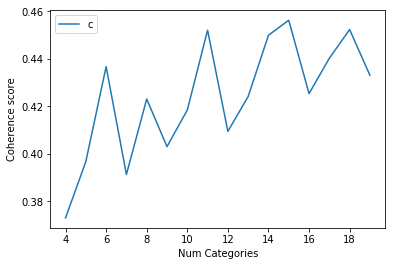

In [116]:
# Show graph
limit=20; start=4; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Categories")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [117]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 4  has Coherence Value of 0.3731
Num Topics = 5  has Coherence Value of 0.3968
Num Topics = 6  has Coherence Value of 0.4368
Num Topics = 7  has Coherence Value of 0.3914
Num Topics = 8  has Coherence Value of 0.4231
Num Topics = 9  has Coherence Value of 0.4031
Num Topics = 10  has Coherence Value of 0.4185
Num Topics = 11  has Coherence Value of 0.4521
Num Topics = 12  has Coherence Value of 0.4095
Num Topics = 13  has Coherence Value of 0.4242
Num Topics = 14  has Coherence Value of 0.45
Num Topics = 15  has Coherence Value of 0.4563
Num Topics = 16  has Coherence Value of 0.4254
Num Topics = 17  has Coherence Value of 0.4403
Num Topics = 18  has Coherence Value of 0.4524
Num Topics = 19  has Coherence Value of 0.4331


In [150]:
# Select the model and print the topics (model 3 with 14 categories)
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.021*"flygtning" + 0.016*"barn" + 0.011*"ar" + 0.008*"politi" + '
  '0.008*"syrien" + 0.008*"familie" + 0.007*"land" + 0.007*"menneske" + '
  '0.006*"bo" + 0.006*"ifølge"'),
 (1,
  '0.027*"indvandrer" + 0.013*"dansk" + 0.010*"procent" + 0.009*"dansker" + '
  '0.009*"ar" + 0.008*"ga" + 0.008*"arbejde" + 0.007*"vestlig" + '
  '0.006*"efterkommer" + 0.006*"tale"'),
 (2,
  '0.052*"tyskland" + 0.049*"tysk" + 0.035*"merkel" + 0.023*"norge" + '
  '0.016*"angela" + 0.015*"norsk" + 0.013*"nsu" + 0.011*"kansler" + '
  '0.010*"parti" + 0.009*"afd"'),
 (3,
  '0.043*"eu" + 0.025*"land" + 0.022*"europa" + 0.010*"flygtning" + '
  '0.009*"kæmpe" + 0.008*"bad" + 0.007*"europæisk" + 0.007*"tyrkiet" + '
  '0.006*"grænse" + 0.006*"myanmar"'),
 (4,
  '0.025*"danmark" + 0.018*"dansk" + 0.015*"regering" + 0.015*"flygtning" + '
  '0.012*"kommune" + 0.011*"ar" + 0.009*"land" + 0.007*"mene" + '
  '0.006*"venstre" + 0.006*"folkeparti"'),
 (5,
  '0.021*"usa" + 0.016*"præsident" + 0.014*"amerikansk" + 0.0

## Skifter til den anden artikel: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [163]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(14)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.3958,"usa, politi, præsident, amerikansk, trumpe, obama, medie, skrive, muslim, muslimsk","[mexicansk, hær, befri, migrant, holde, fange, gruppe, kriminel, nordlig, mexico, offer, central..."
1,1,7.0,0.7527,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[italiensk, kystvagt, udrette, torsdag, heltepræstation, redde, afrikansk, migrant, migrant, stu..."
2,2,0.0,0.5022,"barn, ga, familie, fortælle, ung, dag, ar, bo, gruppe, kvinde","[politi, københavn, lufthavn, lade, illegal, migrant, slippe, kontrol, sagtens, stoppe, lyde, pa..."
3,3,7.0,0.5673,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[antal, dø, afrikansk, asylsøger, italiensk, lampedusa, belyse, europa, problem, handtere, flygt..."
4,4,7.0,0.7348,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[hab, fremtid, dødelig, udgang, person, sidste, ar, omkomme, forsøg, afrika, europa, rekordmange..."
5,5,7.0,0.6305,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[time, flyde, rund, dø, krop, fortælle, arig, germani, nagassi, glemme, opleve, torsdag, morgen,..."
6,6,7.0,0.6472,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[malta, premierminister, joseph, muscat, europæisk, farvand, tæt, afrika, kirkegard, overfylde, ..."
7,7,3.0,0.4439,"eu, land, sverige, europa, svensk, tyskland, thorning, tysk, helle, grænse","[sen, badkæntning, flygtning, italien, kyse, italien, bede, eu, hjælp, handtere, kraftig, strøm,..."
8,8,7.0,0.7000,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[dødstal, voks, fiskerbad, asylansøger, kur, australien, forlise, nat, onsdag, dansk, tid, indon..."
9,9,1.0,0.4278,"indvandrer, parti, vestlig, procent, politisk, stemme, ga, tale, valg, social","[kina, premierminister, wen, jibao, opfordre, land, virksomhed, behandle, ung, ansat, forlade, h..."


In [164]:
# join the topics back to the original dataset
dr_data_topic = pd.concat([dr_data, df_dominant_topic], sort=True, axis=1)
topic_date = dr_data_topic.groupby(['Publish date', 'Dominant_Topic']).count()
topic_date.tail()

,,Text,Title,URL,Date month,Text lemmatized,Document_No,Topic_Perc_Contrib,Keywords,Text
Publish date,Dominant_Topic,,,,,,,,,
2019-08-10 17:15:00+00:00,0.0,1,1,1,1,1,1,1,1,1
2019-08-17 07:17:00+00:00,4.0,1,1,1,1,1,1,1,1,1
2019-08-17 18:00:00+00:00,0.0,1,1,1,1,1,1,1,1,1
2019-08-17 18:01:00+00:00,7.0,1,1,1,1,1,1,1,1,1
2019-08-19 19:34:00+00:00,7.0,1,1,1,1,1,1,1,1,1


## Creating the area chart showing change of occurance of article topics over time

In [175]:
# transform data from raw data to percentage (fraction)
dr_data_topic['Date day'] = pd.to_datetime(dr_data_topic['Publish date']).dt.to_period('q')
topics_day = dr_data_topic.groupby(['Date day', 'Dominant_Topic'])['Document_No'].count().reset_index()
topics_day

# We need to transform the data from raw data to percentage (fraction)
topics = topics_day.pivot_table('Document_No', 'Date day', 'Dominant_Topic')
topics.head()
topics.index


PeriodIndex(['2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4',
             '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3'],
            dtype='period[Q-DEC]', name='Date day', freq='Q-DEC')

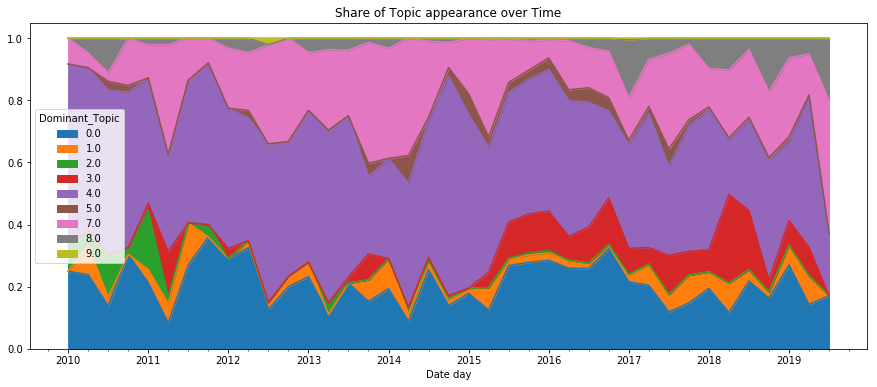

In [176]:
# Normalize Data
normalizedDataFrame = topics.divide(topics.sum(axis=1), axis=0);

import matplotlib.pyplot as plot
 

# Draw a percentage based, stacked area plot
normalizedDataFrame.plot.area(stacked=True, figsize=(15,6), title=('Share of Topic appearance over Time'));

plot.show(block=True);

7. The most representative sentence for each topic

In [167]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(14)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7075,"barn, ga, familie, fortælle, ung, dag, ar, bo, gruppe, kvinde","[koncentration, rund, bord, aarhus, arig, abdullah, mosli, øve, dansk, engelsk, værge, mirjamme,..."
1,1.0,0.5047,"indvandrer, parti, vestlig, procent, politisk, stemme, ga, tale, valg, social","[love, stramning, indvandrer, kræve, arbejdsindsats, dag, danmark, helle, thorning, schmidt, soc..."
2,2.0,0.4960,"asylansøger, rapport, sag, asyl, norge, jens, norsk, afvise, afgørelse, person","[asylansøger, sta, sende, retur, grækenland, sag, behandle, danmark, birthe, rønn, hornbech, bes..."
3,3.0,0.6707,"eu, land, sverige, europa, svensk, tyskland, thorning, tysk, helle, grænse","[forbundskansler, angela, merkel, horst, seehofer, na, frem, kompromis, strid, asylpolitik, domi..."
4,4.0,0.8051,"danmark, dansk, ar, regering, flygtning, land, mene, dansker, tal, procent","[udgift, flygtning, danmark, stige, sen, ar, udgift, fastsla, thomas, gammeltoft, hansen, forske..."
5,5.0,0.5737,"kommune, flygtning, arbejde, job, arbejdsmarked, bolig, lære, finde, beskæftigelse, borgmester","[betale, kigge, kommunegrænse, flygtning, job, fald, konklusion, samarbejde, kommune, sommer, hj..."
6,7.0,0.8920,"flygtning, land, fn, bad, menneske, flygte, ifølge, europa, sen, unhcr","[fartøj, hundred, illegal, immigrant, synke, italiensk, lampedusa, fund, drukne, oplyse, nyhedsb..."
7,8.0,0.5331,"usa, politi, præsident, amerikansk, trumpe, obama, medie, skrive, muslim, muslimsk","[amerikansk, præsident, republikaner, donald, trumpe, udvise, indvandrer, land, ulovlig, republi..."
8,9.0,0.3507,"venstre, støjberg, inger, rasmussen, schmidt, radikal, morten, lars, sf, stramning","[odense, kommune, kaffe, gal, hals, uge, vid, asylansøger, flytte, bydel, vollsmose, pleje, komm..."


8. Frequency Distribution of Word Counts in Documents

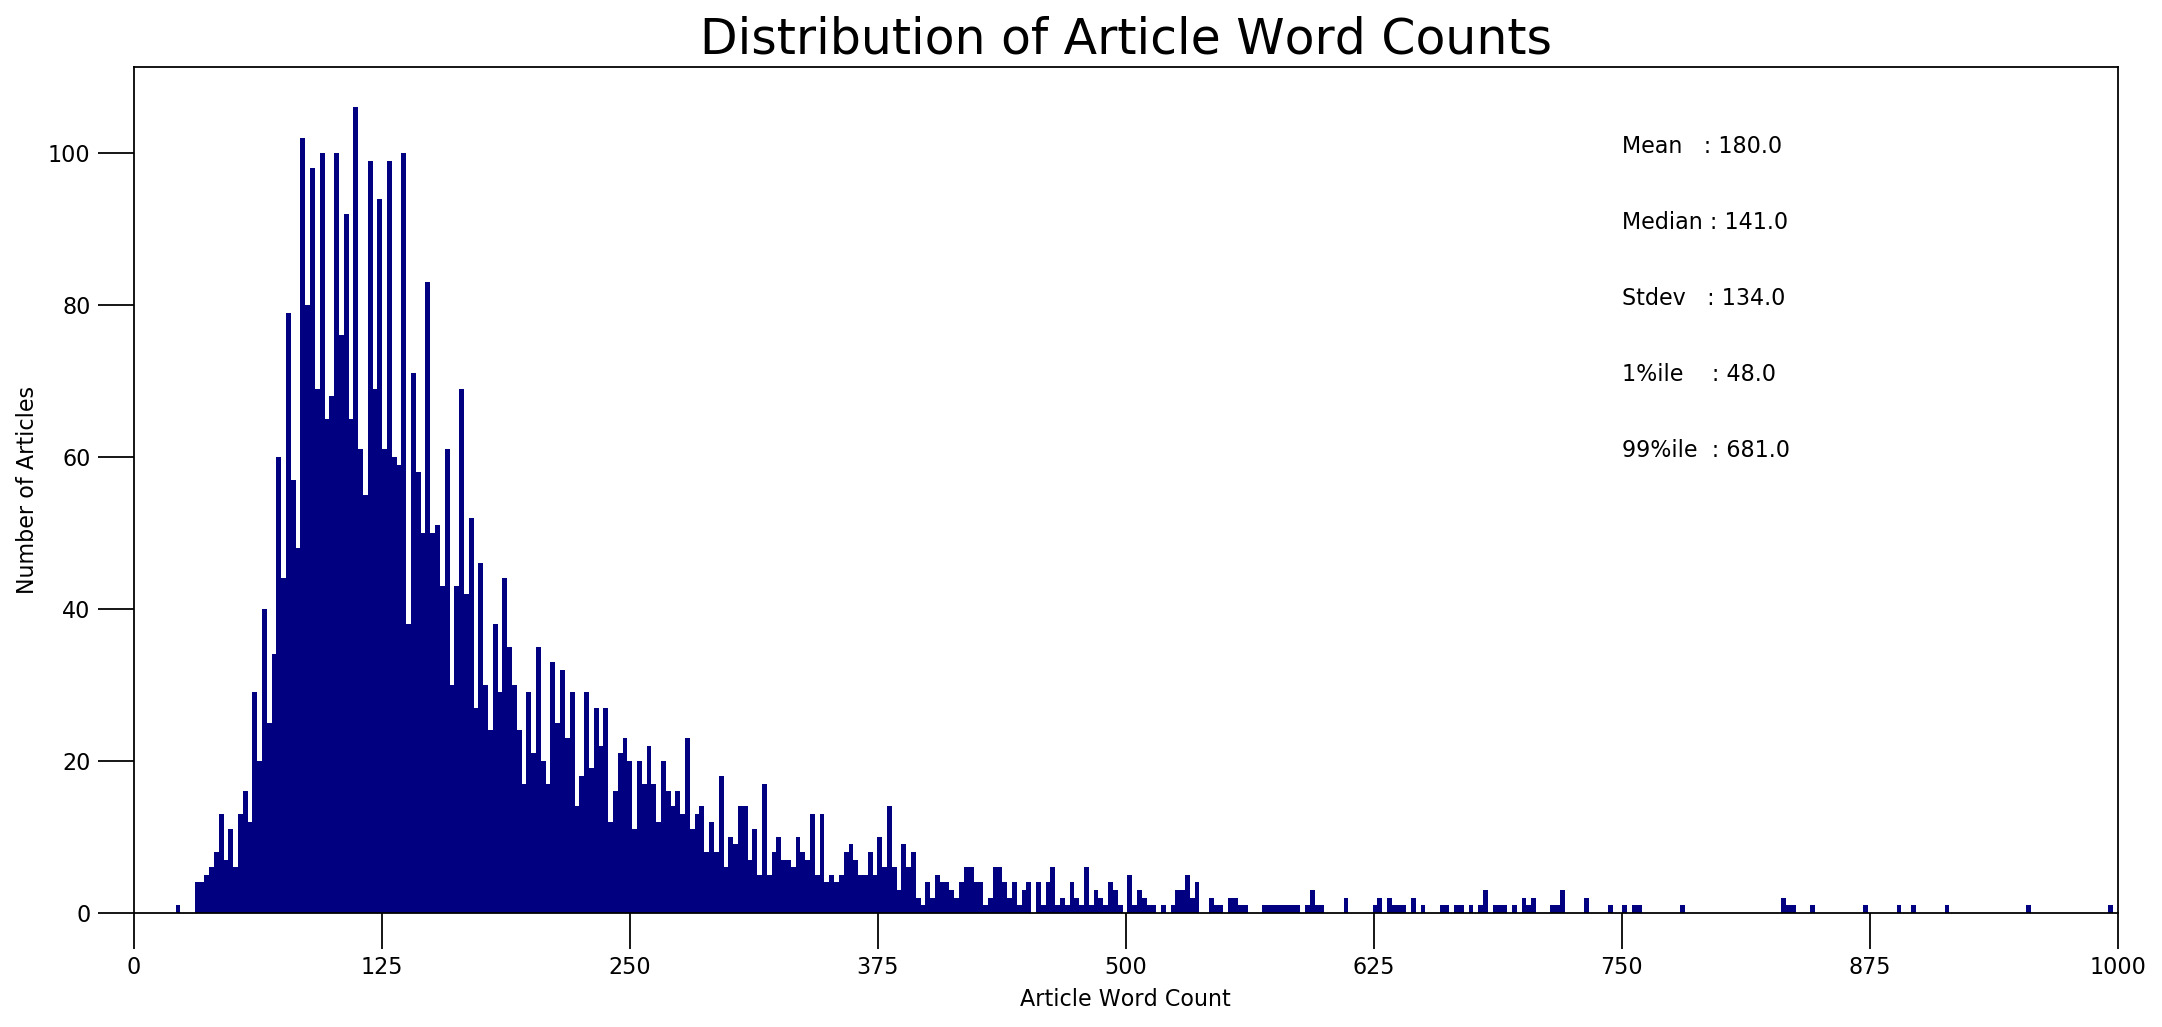

In [168]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Articles', xlabel='Article Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Article Word Counts', fontdict=dict(size=22))
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


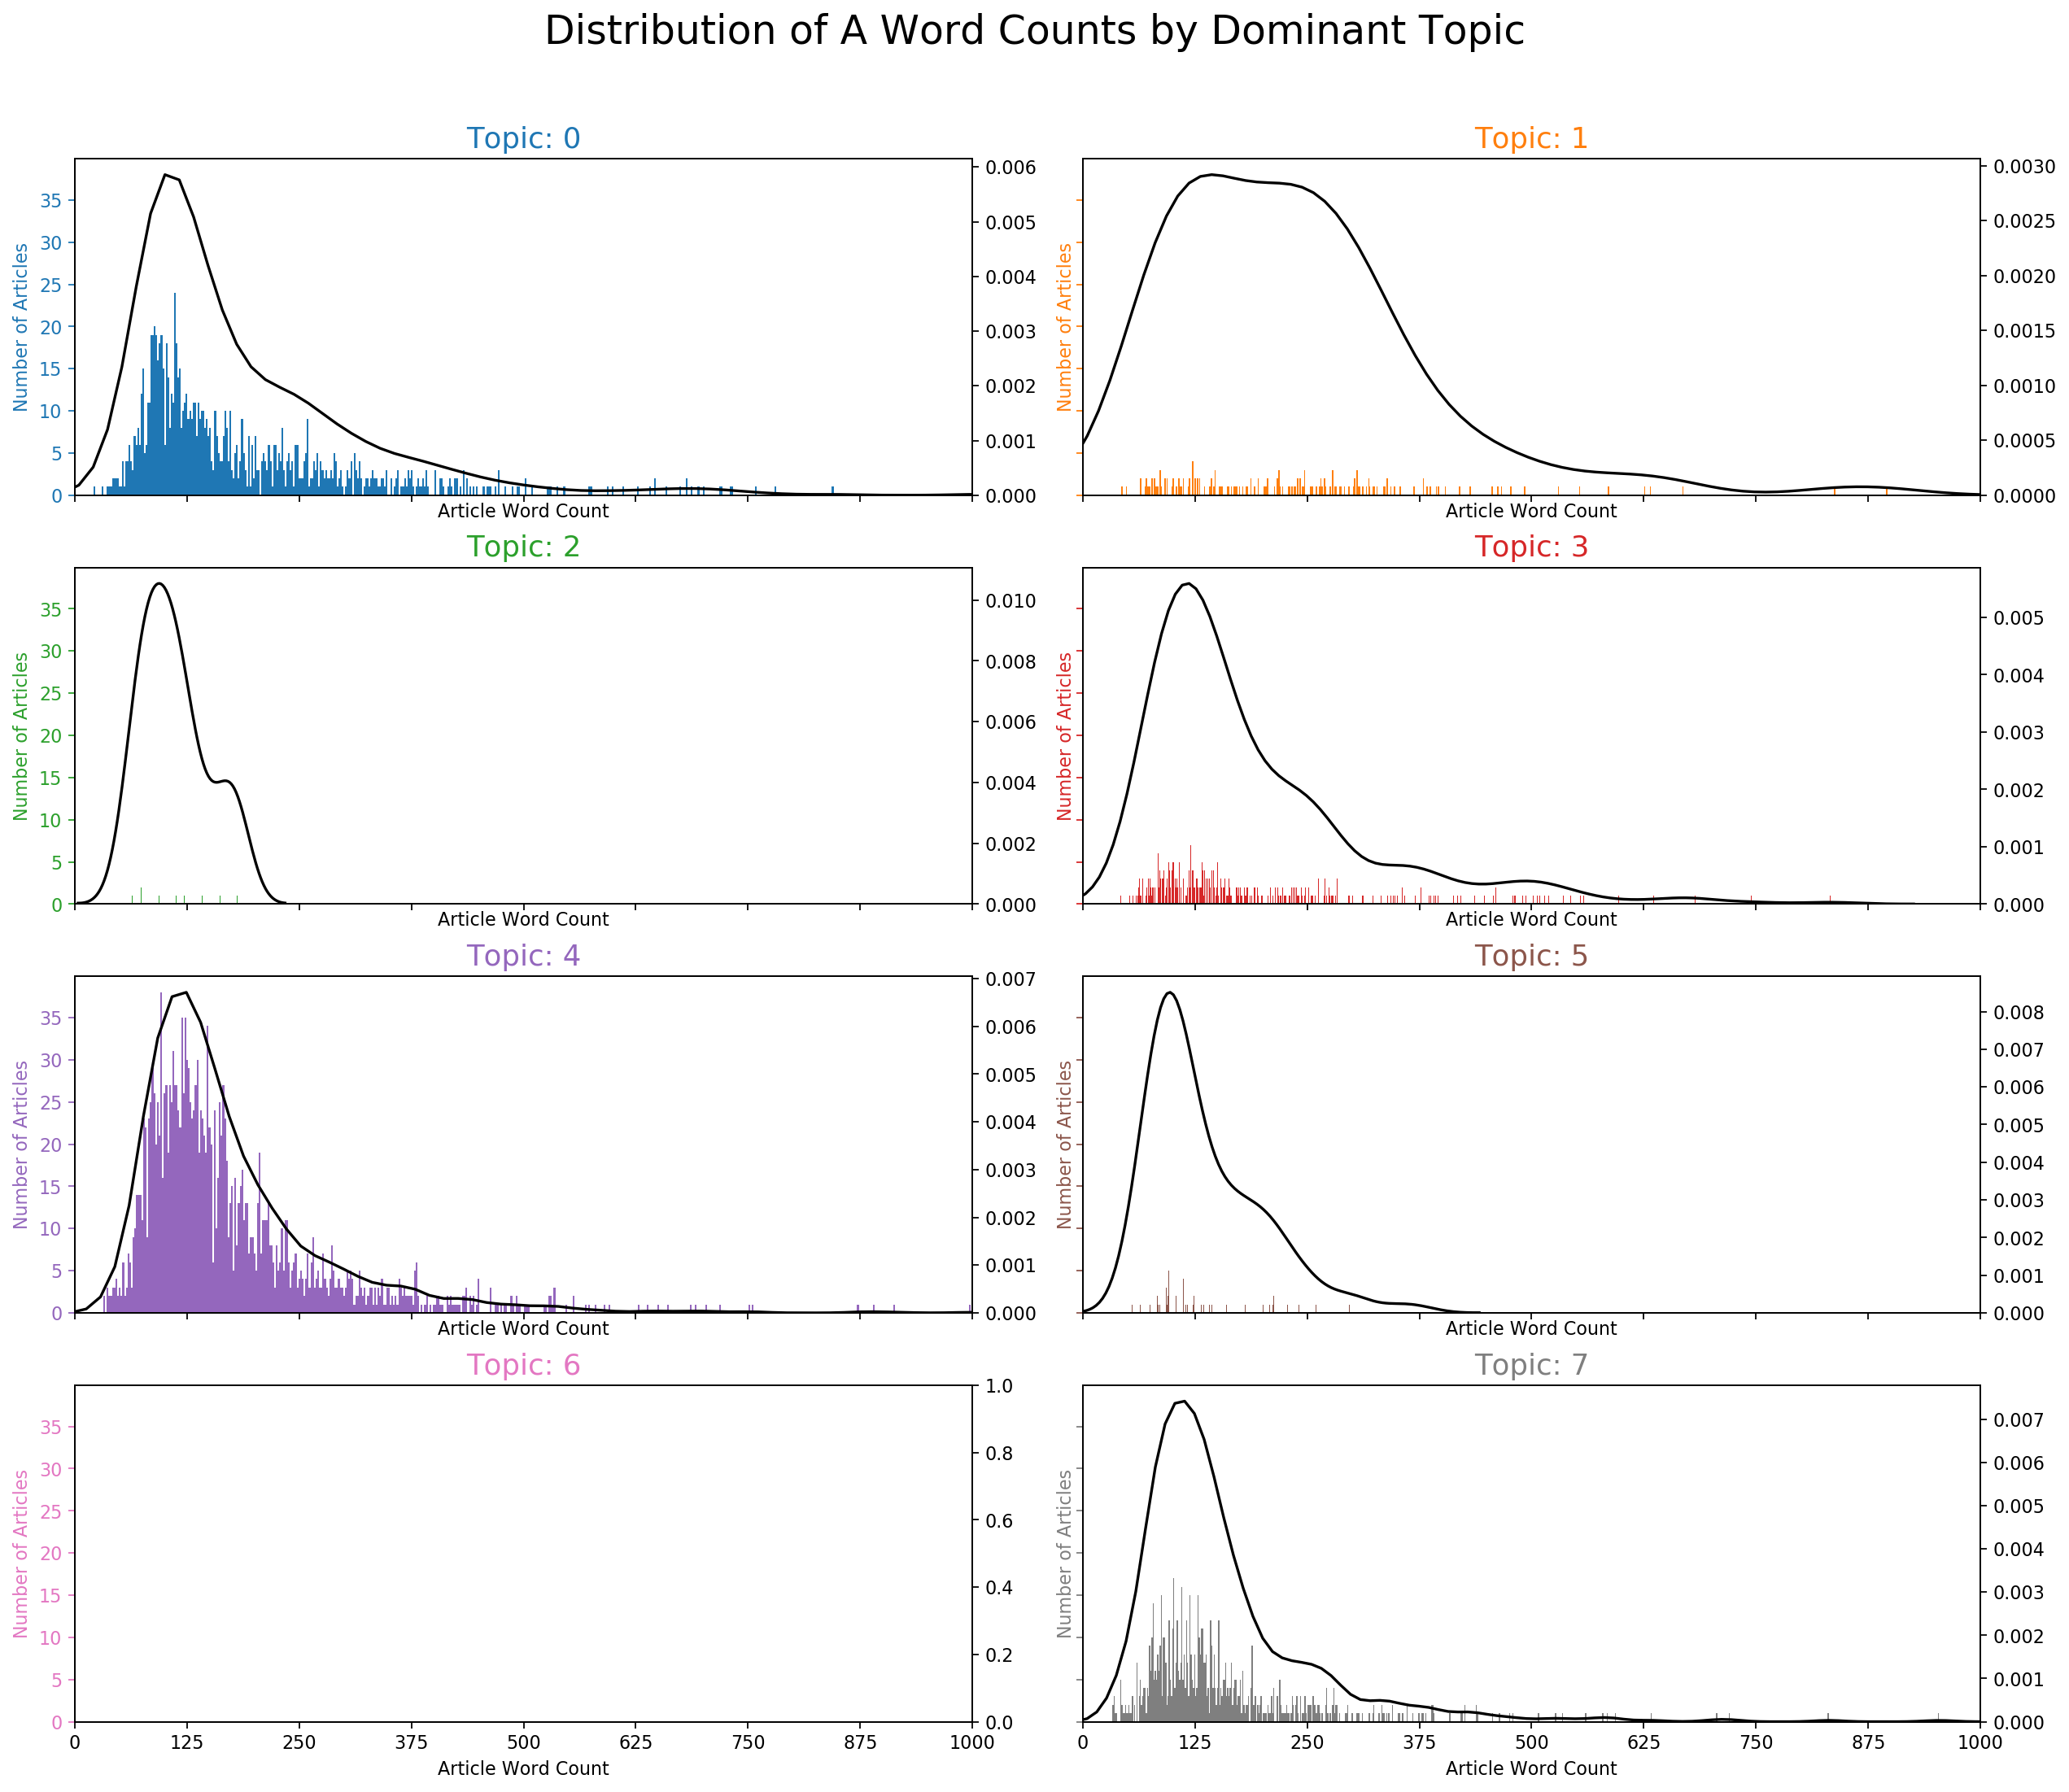

In [169]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Article Word Count')
    ax.set_ylabel('Number of Articles', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of A Word Counts by Dominant Topic', fontsize=22)
plt.show()

9. Word Clouds of Top N Keywords in Each Topic

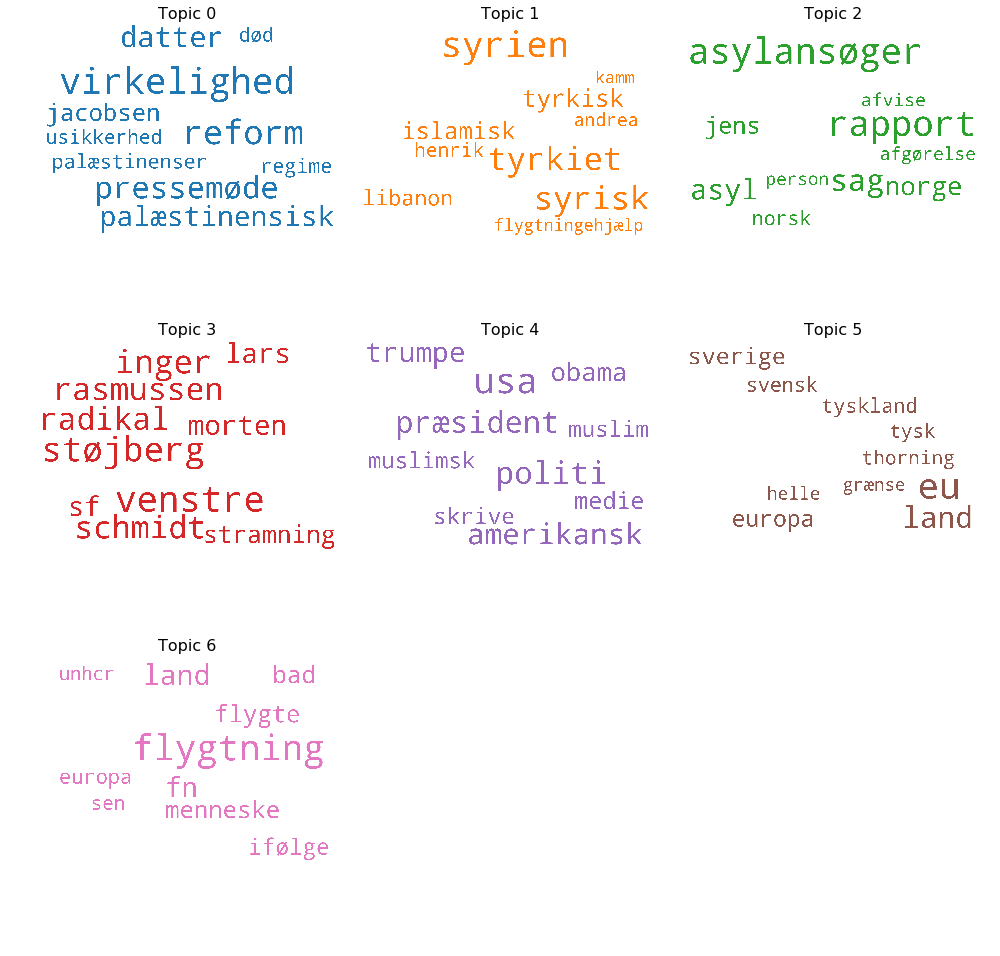

In [170]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(14,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()[:-2]):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

axes.flatten()[-1].axis('off')
axes.flatten()[-2].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

10. Word Counts of Topic Keywords


IndexError: list index out of range

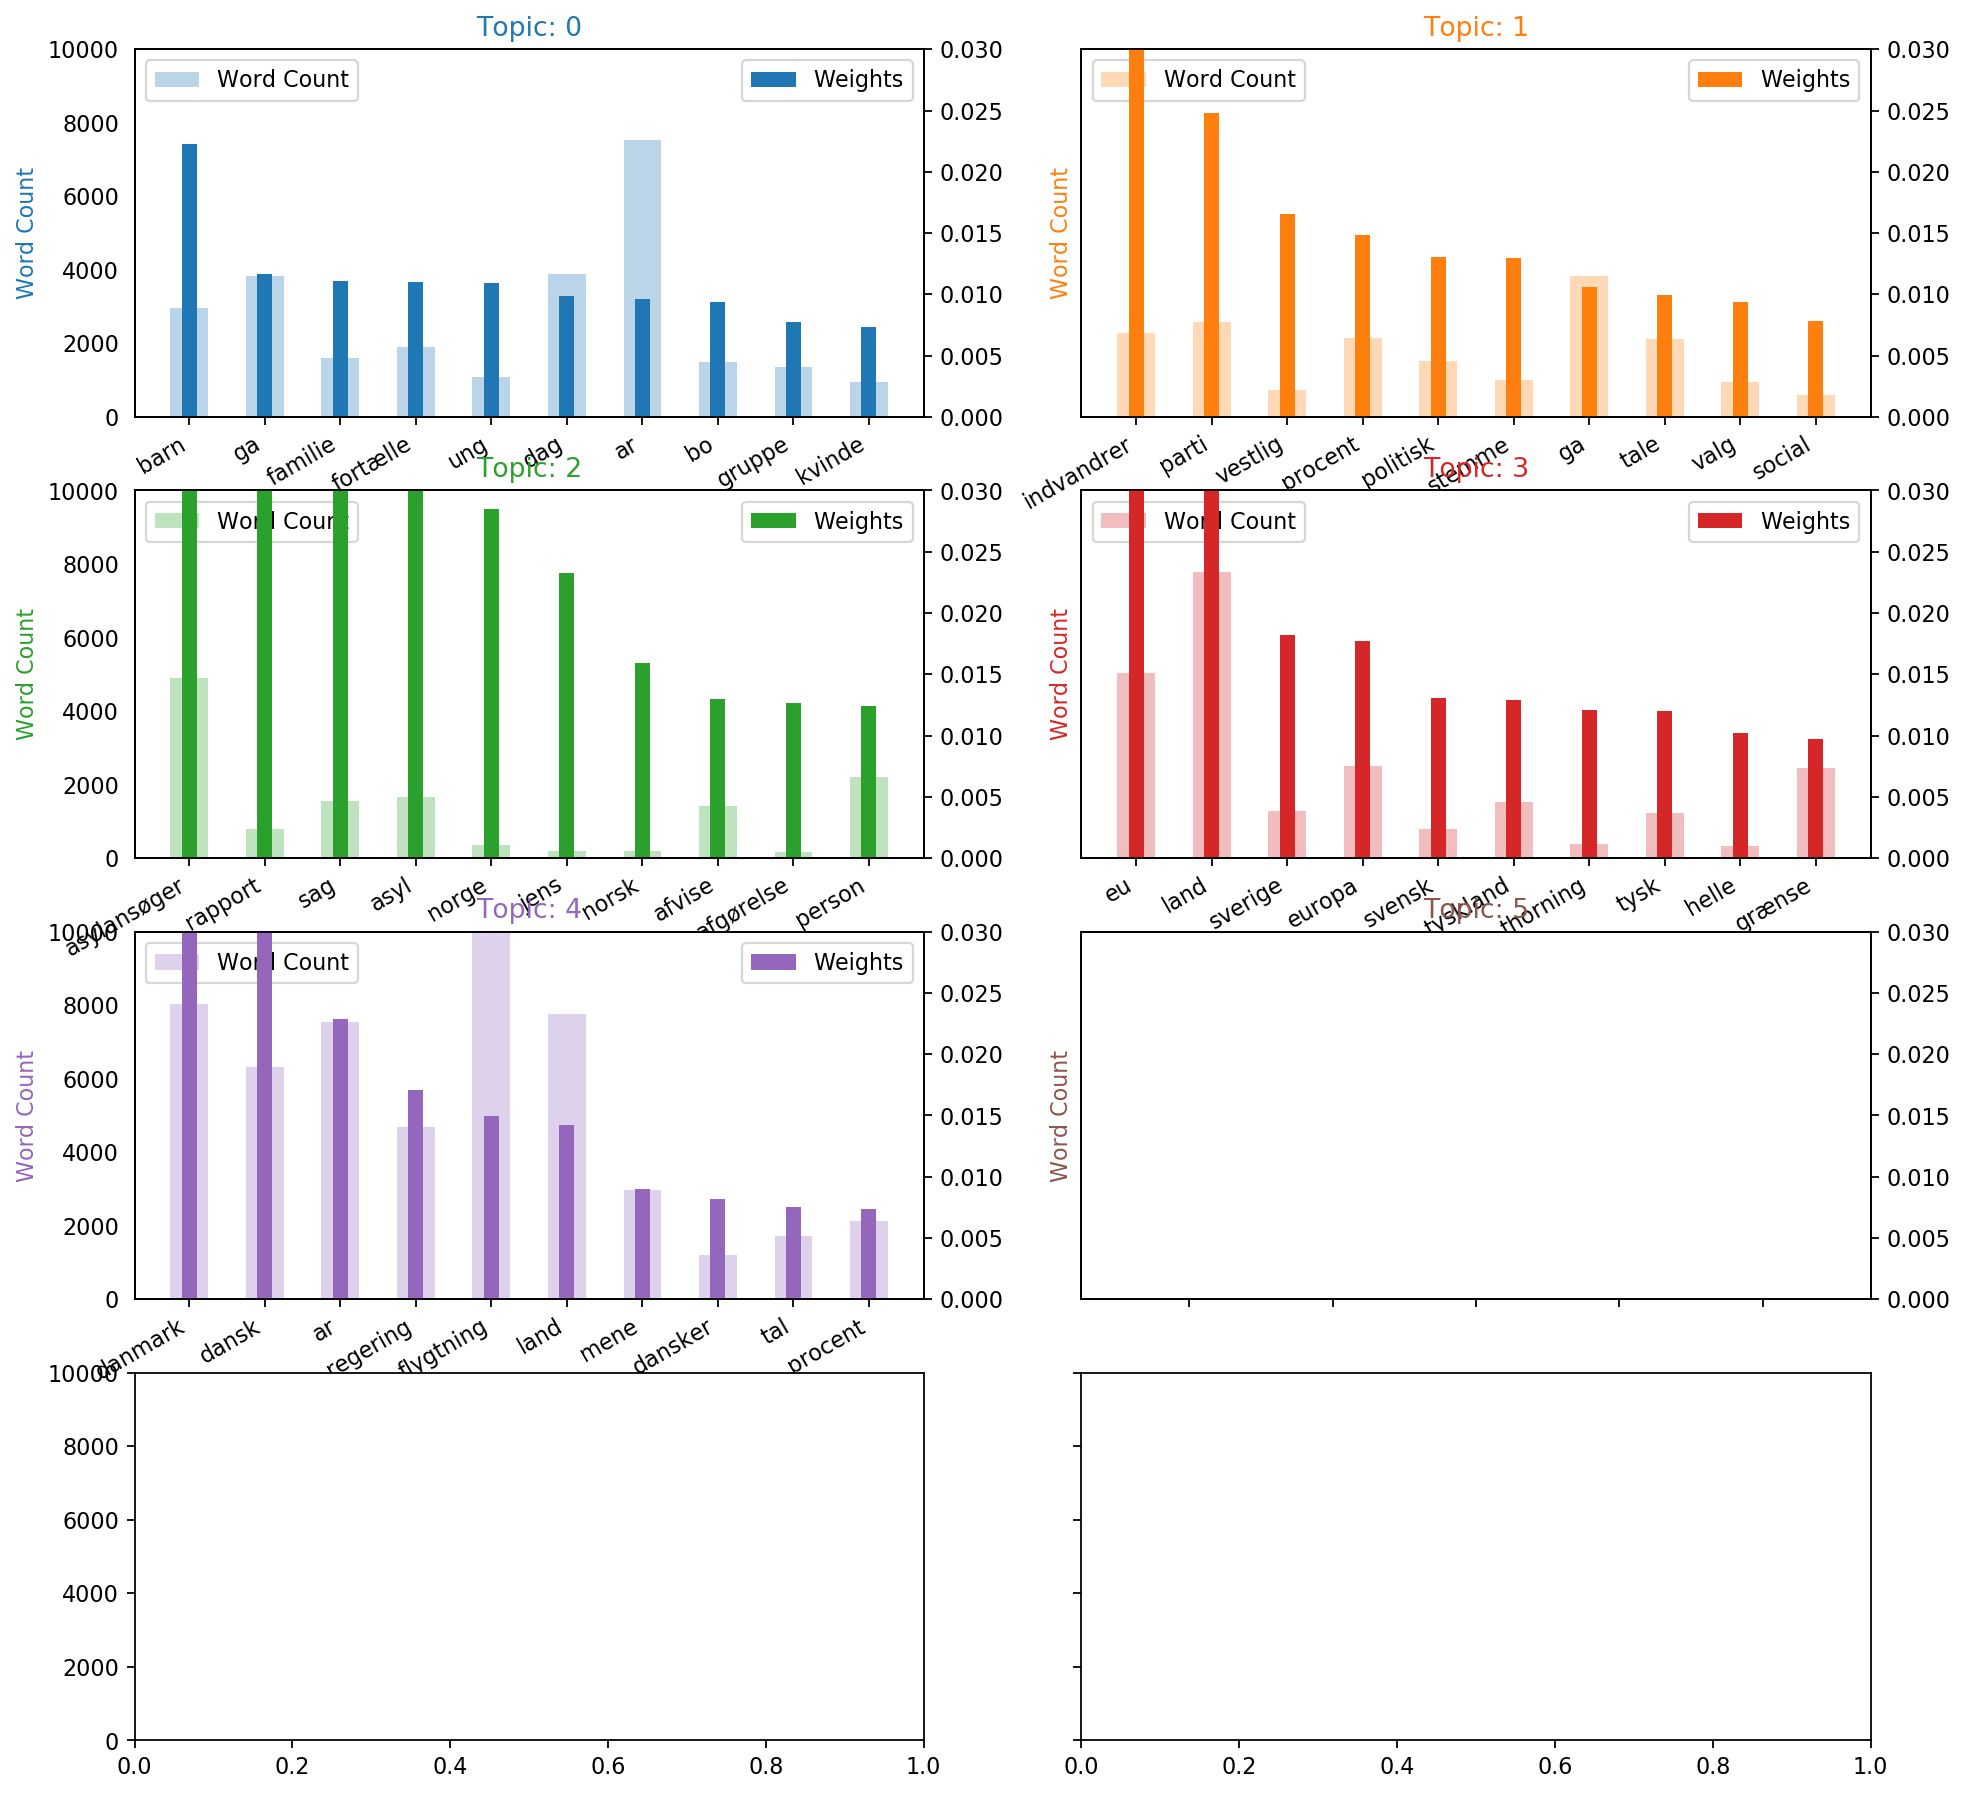

In [171]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()[:-1]):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.03); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

axes.flatten()[-1].axis('off')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


11. Sentence Chart Colored by Topic


12. What are the most discussed topics in the documents?


In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
 

13. t-SNE Clustering Chart

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)
